# <center> Calibrating the QICK for phase coherent readout

### <center> In this demo you will calibrate the QICK clocks to have the same phase.

Before you measure a resonance with your QICK this is the first calibration you should do. It is a calibration for the two synthesizers which belong to the QICK signal generator and the QICK readout, respectively. The two synthesizers are running at the same frequency, but there is initially a constant phase difference $\phi$ between these two synthesizers. Doing this calibration results in you finding that phase difference $\phi$. In your subsequent measurements, you can specify this initial phase difference $\phi$ to compensate for it. From then on, the signal generator can synthesize any frequency and then if you read in data (doing a digital down conversion in the process), the readout will still be phase coherent with respect to the signal generator. 

<center> The angular frequency $\omega = 2 \pi f$ .

<center> Also, $\phi = (\omega t) + \phi_0$. 

<center> So, $\phi = (2 \pi f)*t + \phi_0 $. 

If $f$ goes up linearly, the phase difference will also change linearly (it will either increase or decrease, depending on whether the readout is ahead or behind of the signal generator- this is randomly determined each time the board clocks are initialized). Once the phase hits 360 degrees it cycles back to 0 again. For a readout frequency of interest $f_i$ there is a corresponding phase difference $\phi_i$. In this demonstration we assume $f_i \approx 180$ MHz. You can plot $\phi(f)$ and evaluate $\phi(f_i)=\phi_i$.

In [1]:
# Import the QICK drivers and auxiliary libraries
from qick import *
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Load bitstream with custom overlay
soc = QickSoc('../qick_lib/qick.bit')


### Hardware Configuration

tProc channel 6   : DAC 229 CH2  <-> Readout channel 1 : ADC 224 CH1
* This program has an associated assembly language file which needs to be located in the same directory when you run it: <code> phase_calibration.asm </code>


In [3]:
# Constant, real envelope.
xg_i = 30000*np.ones(320)
xg_q = np.zeros(len(xg_i))

# Upload waveform.
gen = soc.gens[5].load(addr=0,xin_i=xg_i, xin_q=xg_q)

# Output frequency f0_v.
###################
# Try it yourself ! Change the output frequency.
###################
# f0_v = np.linspace(180,180.006,70)
f0_v = np.linspace(420,425,30) 

fi_v = np.zeros(len(f0_v))
td_v = np.zeros(len(f0_v))
for ii in np.arange(len(f0_v)):
    f0 = f0_v[ii]
    
    f0_dac_int = freq2reg(f=f0) # Frequency of signal generator
    soc.tproc.single_write(addr=123, data=f0_dac_int)

    # Output phase.
    fi0 = 0
    tmp = deg2reg(fi0)
    soc.tproc.single_write(addr=124, data=tmp)

    # Configure readout.
    soc.readouts[1].set_out("product")
    #soc.readouts[1].set_freq(f0)
    soc.readouts[1].set_freq_int(2*f0_dac_int) # Using the same frequency multiplied by 2
    soc.avg_bufs[1].config(address=0, length=1000)
    soc.avg_bufs[1].enable()
    
#     time.sleep(1)

    # Load program.
    soc.tproc.load_program("01_phase_calibration.asm")

    # Start tProc.
    soc.tproc.stop()
    soc.tproc.start()

    time.sleep(0.1)

    # Get data.
    [xi,xq] = soc.get_decimated(ch=1, length=1000)
    x = xi +1j*xq

    # Average to improve calibration.
    xavg = np.sum(x)/len(x)

    # Calculate calibration phase.
    A = np.abs(xavg)
    fi = np.angle(xavg,deg=True)
    if fi<0:
        fi = fi+360

    print("Iteration i = %d, freq_i = %f MHz, A = %f, phi_i = %f degrees" %(ii,f0, A, fi))
    
    # Save results.
    fi_v[ii] = fi

Iteration i = 0, freq_i = 420.000000 MHz, A = 575.192295, phi_i = 329.781350 degrees
Iteration i = 1, freq_i = 420.172414 MHz, A = 575.447894, phi_i = 350.961780 degrees
Iteration i = 2, freq_i = 420.344828 MHz, A = 575.350556, phi_i = 11.991743 degrees
Iteration i = 3, freq_i = 420.517241 MHz, A = 575.389376, phi_i = 33.051365 degrees
Iteration i = 4, freq_i = 420.689655 MHz, A = 575.238293, phi_i = 54.107480 degrees
Iteration i = 5, freq_i = 420.862069 MHz, A = 575.059660, phi_i = 75.112444 degrees
Iteration i = 6, freq_i = 421.034483 MHz, A = 575.214556, phi_i = 96.172367 degrees
Iteration i = 7, freq_i = 421.206897 MHz, A = 575.452294, phi_i = 117.213653 degrees
Iteration i = 8, freq_i = 421.379310 MHz, A = 575.405472, phi_i = 138.245589 degrees
Iteration i = 9, freq_i = 421.551724 MHz, A = 575.099874, phi_i = 159.286829 degrees
Iteration i = 10, freq_i = 421.724138 MHz, A = 575.228449, phi_i = 180.328400 degrees
Iteration i = 11, freq_i = 421.896552 MHz, A = 574.812569, phi_i = 20

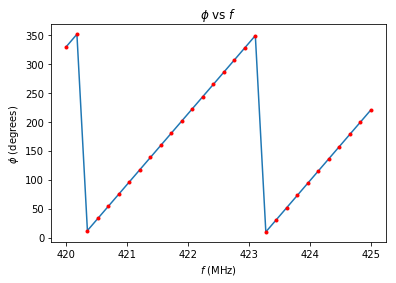

In [4]:
# Plot results.
plt.figure(2)
plt.plot(f0_v,fi_v)
plt.plot(f0_v,fi_v, marker='.', linestyle="None",color="Red")
plt.title(r"$\phi$ vs $f$")
plt.ylabel(r"$\phi$ (degrees)")
plt.xlabel(r"$f$ (MHz)")
plt.savefig("images/Phase_calibration.pdf", dpi=350)